# Comparison with R Package

This notebook compares our Python implementation of permutation weighting with the original R package. We'll use the rpy2 library to call the R package and compare results.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import time

# Import our Python implementation
from permutation_weighting import PW

# Set up plotting
sns.set_style('whitegrid')
np.random.seed(42)

## Generate Kang-Schafer Data

We'll generate data using the same process as in the Kang-Schafer simulation.

In [13]:
def generate_kang_schafer_data(n=1000, nonlinear=False):
    """
    Generate data according to the Kang and Schafer (2007) simulation.
    
    Parameters
    ----------
    n : int
        Number of observations
    nonlinear : bool
        Whether to use nonlinear transformations of the covariates
        
    Returns
    -------
    X : array
        Covariate matrix
    A : array
        Treatment assignment
    Y : array
        Outcome values
    X_mis : array, optional
        Misspecified covariate matrix (if nonlinear=True)
    """
    # Generate covariates
    X = np.random.normal(size=(n, 4))
    
    # Generate propensity scores
    propensity = 1 / (1 + np.exp(X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]))
    
    # Generate treatment
    A = np.random.binomial(1, propensity, size=n)
    
    # Generate outcome (true treatment effect is 0)
    Y = 210 + 27.4 * X[:, 0] + 13.7 * X[:, 1] + 13.7 * X[:, 2] + 13.7 * X[:, 3] + np.random.normal(size=n)
    
    if nonlinear:
        # Create misspecified covariates
        X_mis = np.column_stack([
            np.exp(X[:, 0] / 2),
            X[:, 1] * (1 + np.exp(X[:, 0])) ** (-1) + 10,
            (X[:, 0] * X[:, 2] / 25 + 0.6) ** 3,
            (X[:, 1] + X[:, 3] + 20) ** 2
        ])
        return X, A, Y, X_mis
    else:
        return X, A, Y
    
# Generate data for both scenarios
n_samples = 1000
X, A, Y = generate_kang_schafer_data(n=n_samples, nonlinear=False)
X_mis, A_mis, Y_mis, X_nonlinear = generate_kang_schafer_data(n=n_samples, nonlinear=True)

## Run Permutation Weighting in Python

Let's estimate weights using our Python implementation.

In [14]:
print("Estimating weights with Python implementation...")

# Linear case
start_time = time.time()
pw_logit_py = PW(A, X, classifier='logit', num_replicates=100)
py_logit_time = time.time() - start_time

start_time = time.time()
pw_boost_py = PW(A, X, classifier='boosting', num_replicates=100)
py_boost_time = time.time() - start_time

# Nonlinear case
start_time = time.time()
pw_logit_mis_py = PW(A_mis, X_nonlinear, classifier='logit', num_replicates=100)
py_logit_mis_time = time.time() - start_time

start_time = time.time()
pw_boost_mis_py = PW(A_mis, X_nonlinear, classifier='boosting', num_replicates=100)
py_boost_mis_time = time.time() - start_time

# Estimate treatment effects
# Linear case
unweighted_py = sm.OLS(Y, sm.add_constant(A)).fit()
logit_py = sm.WLS(Y, sm.add_constant(A), weights=pw_logit_py['weights']).fit()
boost_py = sm.WLS(Y, sm.add_constant(A), weights=pw_boost_py['weights']).fit()

# Nonlinear case
unweighted_mis_py = sm.OLS(Y_mis, sm.add_constant(A_mis)).fit()
logit_mis_py = sm.WLS(Y_mis, sm.add_constant(A_mis), weights=pw_logit_mis_py['weights']).fit()
boost_mis_py = sm.WLS(Y_mis, sm.add_constant(A_mis), weights=pw_boost_mis_py['weights']).fit()

# Extract results
py_unweighted = (unweighted_py.params[1], unweighted_py.bse[1])
py_logit = (logit_py.params[1], logit_py.bse[1])
py_boost = (boost_py.params[1], boost_py.bse[1])

py_unweighted_mis = (unweighted_mis_py.params[1], unweighted_mis_py.bse[1])
py_logit_mis = (logit_mis_py.params[1], logit_mis_py.bse[1])
py_boost_mis = (boost_mis_py.params[1], boost_mis_py.bse[1])

Estimating weights with Python implementation...


## Run Permutation Weighting in R

If R is available, let's estimate weights using the original R package.

In [15]:
try:
    import rpy2
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    import rpy2.robjects.numpy2ri
    
    # Initialize R
    r = ro.r
    
    # Activate auto-conversion for NumPy arrays
    rpy2.robjects.numpy2ri.activate()
    
    # Install the pw package if not already installed
    r('''
    if (!require("pw")) {
        if (!require("devtools")) {
            install.packages("devtools")
        }
        devtools::install_github("ddimmery/pw")
    }
    ''')
    
    # Import pw package
    pw_r = importr('pw')
    
    # Check if installation was successful
    print("R package 'pw' loaded successfully.")
    r_available = True
    
except Exception as e:
    print(f"Error setting up R connection: {e}")
    print("Will proceed with Python implementation only.")
    r_available = False
    

R package 'pw' loaded successfully.


In [16]:
if r_available:
    print("Estimating weights with R implementation...")
    
    # Convert data to R format
    r_A = ro.FloatVector(A)
    r_X = ro.r.matrix(ro.FloatVector(X.flatten()), nrow=X.shape[0], ncol=X.shape[1])
    r_Y = ro.FloatVector(Y)
    
    r_A_mis = ro.FloatVector(A_mis)
    r_X_mis = ro.r.matrix(ro.FloatVector(X_nonlinear.flatten()), nrow=X_nonlinear.shape[0], ncol=X_nonlinear.shape[1])
    r_Y_mis = ro.FloatVector(Y_mis)
    
    # Properly assign variables in R environment
    r.assign("A", r_A)
    r.assign("X", r_X)
    r.assign("Y", r_Y)
    
    r.assign("A_mis", r_A_mis)
    r.assign("X_mis", r_X_mis)
    r.assign("Y_mis", r_Y_mis)
    
    # Estimate weights with logistic regression in R
    start_time = time.time()
    r('''
    set.seed(42)
    pw_logit_r <- PW(A, X, classifier="logit", num_replicates=100)
    ''')
    r_logit_time = time.time() - start_time
    
    start_time = time.time()
    r('''
    pw_logit_mis_r <- PW(A_mis, X_mis, classifier="logit", num_replicates=100)
    ''')
    r_logit_mis_time = time.time() - start_time
    
    # Estimate weights with boosting in R
    start_time = time.time()
    r('''
    pw_boost_r <- PW(A, X, classifier="boosting", num_replicates=100)
    ''')
    r_boost_time = time.time() - start_time
    
    start_time = time.time()
    r('''
    pw_boost_mis_r <- PW(A_mis, X_mis, classifier="boosting", num_replicates=100)
    ''')
    r_boost_mis_time = time.time() - start_time
    
    # Estimate ATE in R
    r('''
    unweighted_r <- lm(Y ~ A)
    logit_r <- lm(Y ~ A, weights=pw_logit_r$weights)
    boost_r <- lm(Y ~ A, weights=pw_boost_r$weights)
    
    unweighted_mis_r <- lm(Y_mis ~ A_mis)
    logit_mis_r <- lm(Y_mis ~ A_mis, weights=pw_logit_mis_r$weights)
    boost_mis_r <- lm(Y_mis ~ A_mis, weights=pw_boost_mis_r$weights)
    ''')
    
    # Extract results from R
    r_unweighted = (r('unweighted_r$coefficients[2]')[0], r('summary(unweighted_r)$coefficients[2, 2]')[0])
    r_logit = (r('logit_r$coefficients[2]')[0], r('summary(logit_r)$coefficients[2, 2]')[0])
    r_boost = (r('boost_r$coefficients[2]')[0], r('summary(boost_r)$coefficients[2, 2]')[0])
    
    r_unweighted_mis = (r('unweighted_mis_r$coefficients[2]')[0], r('summary(unweighted_mis_r)$coefficients[2, 2]')[0])
    r_logit_mis = (r('logit_mis_r$coefficients[2]')[0], r('summary(logit_mis_r)$coefficients[2, 2]')[0])
    r_boost_mis = (r('boost_mis_r$coefficients[2]')[0], r('summary(boost_mis_r)$coefficients[2, 2]')[0])
    
    # Extract weights from R for comparison
    r_weights_logit = ro.r('pw_logit_r$weights')
    r_weights_boost = ro.r('pw_boost_r$weights')
    r_weights_logit_mis = ro.r('pw_logit_mis_r$weights')
    r_weights_boost_mis = ro.r('pw_boost_mis_r$weights')

    # Convert R results to NumPy arrays
    r_weights_logit = np.array(r_weights_logit)
    r_weights_boost = np.array(r_weights_boost)
    r_weights_logit_mis = np.array(r_weights_logit_mis)
    r_weights_boost_mis = np.array(r_weights_boost_mis)
    
    # Deactivate auto-conversion
    rpy2.robjects.numpy2ri.deactivate()
else:
    print("R is not available, skipping R implementation comparison.")

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A, X, classifier = "logit", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A_mis, X_mis, classifier = "logit", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.



Estimating weights with R implementation...


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A, X, classifier = "boosting", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A_mis, X_mis, classifier = "boosting", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.



## Compare Results

If R is available, let's compare the results from both implementations.

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_47827/2574440312.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.pointplot(x='Method', y='Estimate', hue='Implementation',
/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_47827/2574440312.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(x='Method', y='Estimate', hue='Implementation',
/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_47827/2574440312.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(x='Method', y='Estimate', hue='Implementation',
/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_47827/2574440312.py:57: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linest


Treatment Effect Estimates (true effect = 0):
   Implementation      Method       Data   Estimate  Std Error
0          Python  Unweighted     Linear -15.185722   2.175696
1          Python    Logistic     Linear  -2.433199   2.174951
2          Python    Boosting     Linear  -5.736494   2.179486
3          Python  Unweighted  Nonlinear -20.538615   2.205632
4          Python    Logistic  Nonlinear  -7.741408   2.183526
5          Python    Boosting  Nonlinear  -9.774005   2.179729
6               R  Unweighted     Linear -15.185722   2.175696
7               R    Logistic     Linear -14.983715   2.176466
8               R    Boosting     Linear -15.011986   2.178801
9               R  Unweighted  Nonlinear -20.538615   2.205632
10              R    Logistic  Nonlinear -20.574099   2.204344
11              R    Boosting  Nonlinear -20.725060   2.209368


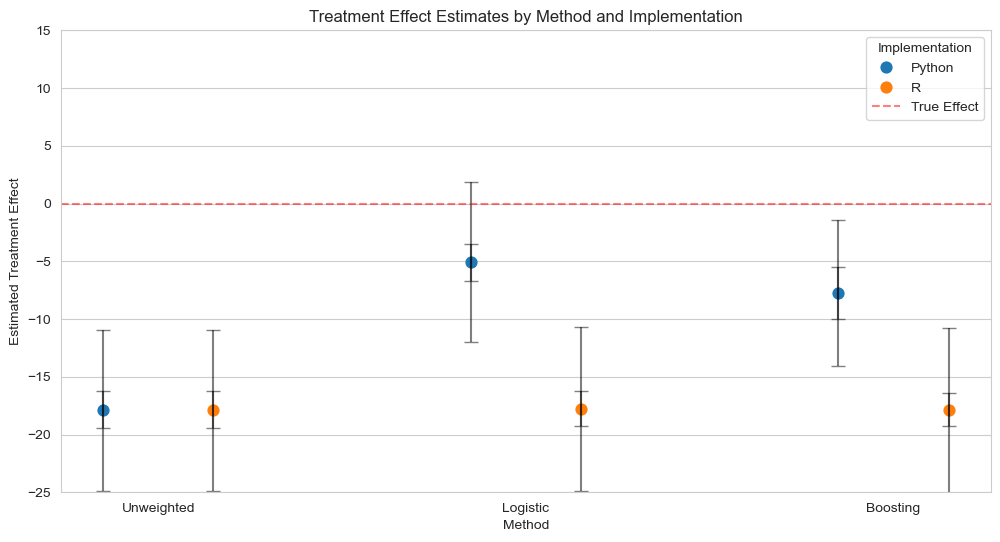

<Figure size 1200x800 with 0 Axes>

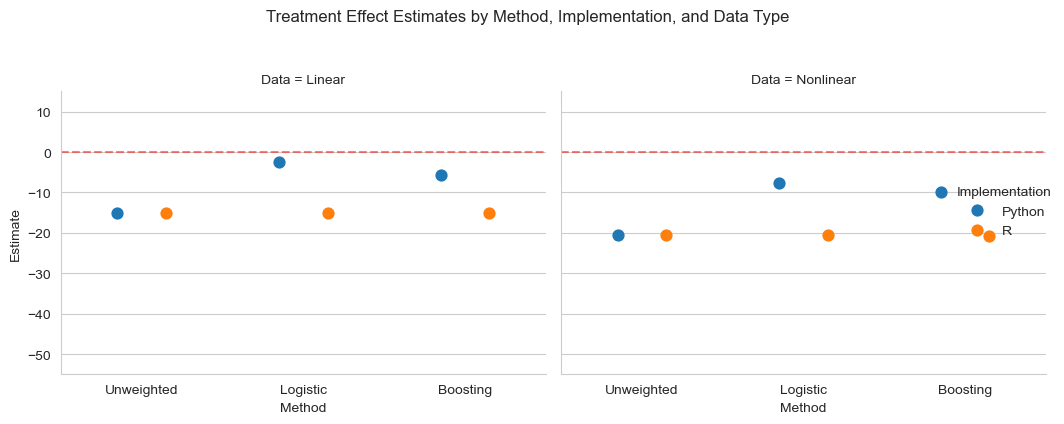


Computation Times (seconds):
  Implementation    Method       Data  Time (s)
0         Python  Logistic     Linear  0.014071
1         Python  Boosting     Linear  0.397417
2         Python  Logistic  Nonlinear  0.125438
3         Python  Boosting  Nonlinear  0.511492
4              R  Logistic     Linear  0.025396
5              R  Boosting     Linear  3.864487
6              R  Logistic  Nonlinear  0.032912
7              R  Boosting  Nonlinear  4.298682


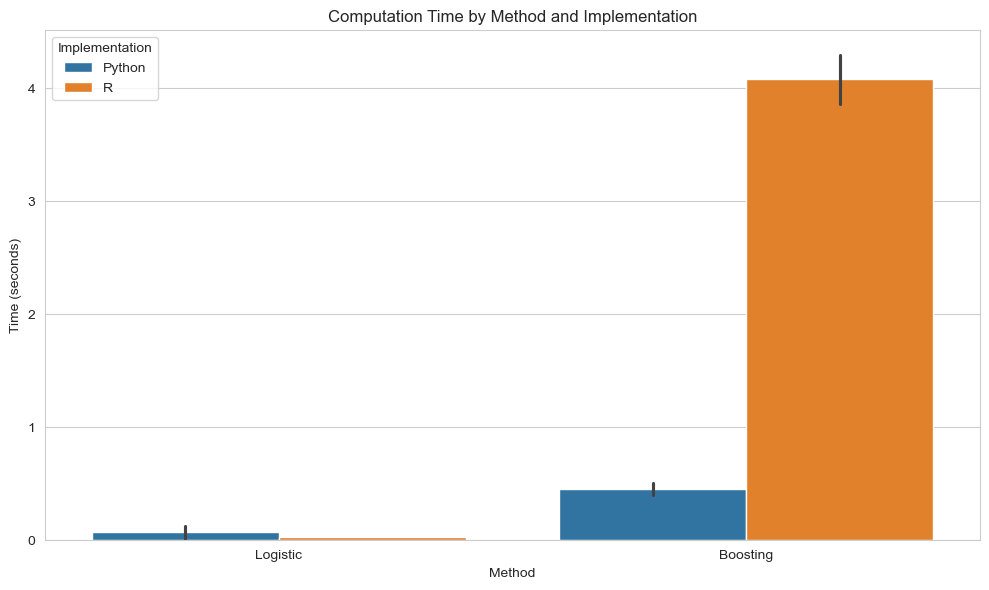

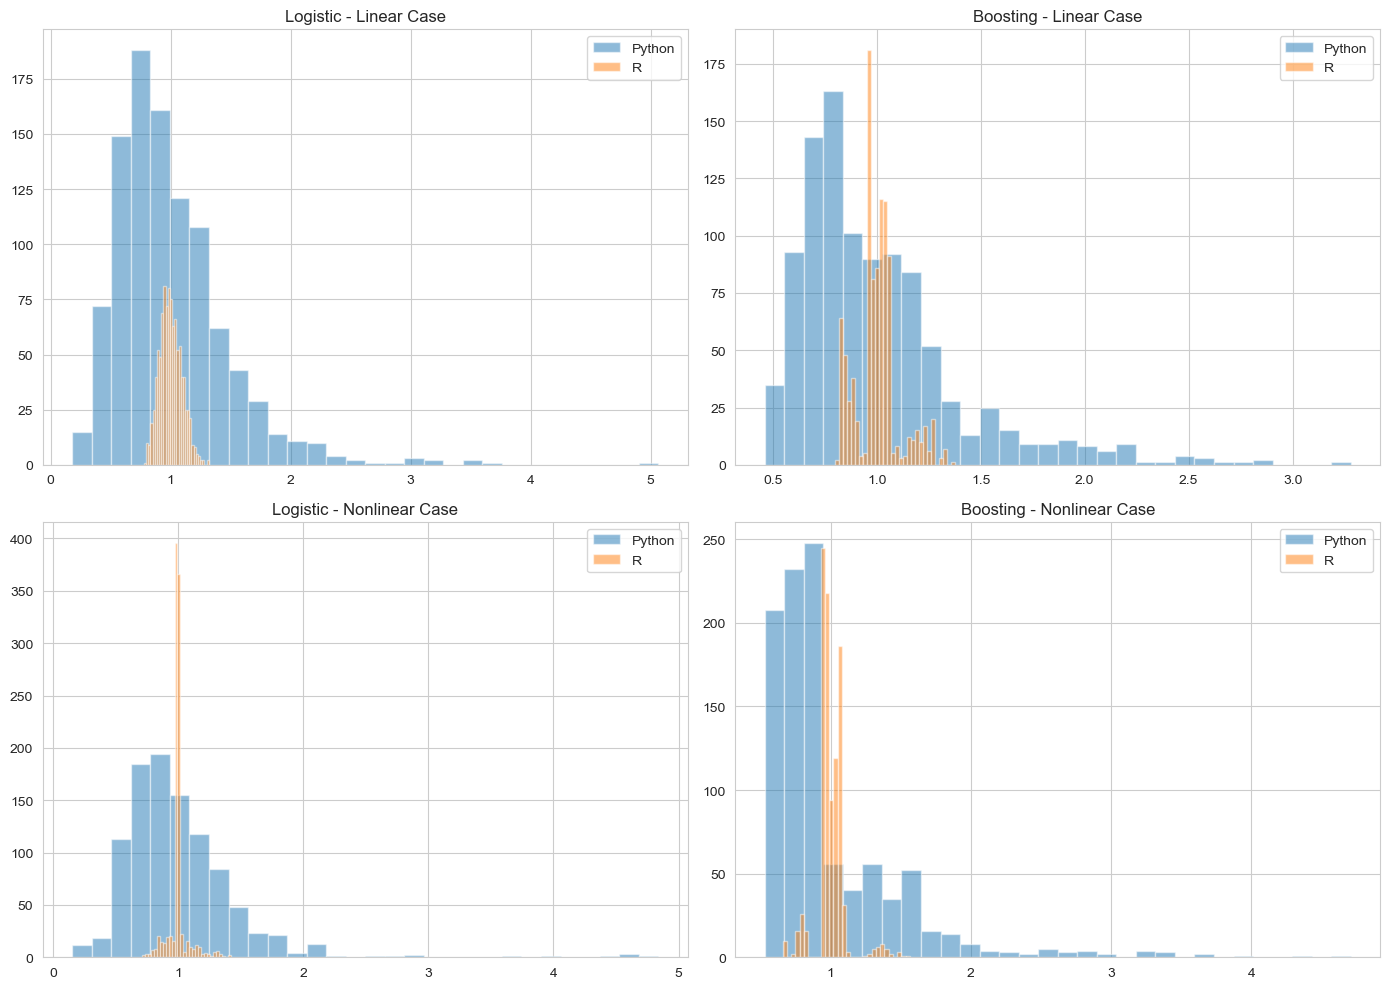

In [17]:
# Create comparison table for estimated treatment effects
results = []

# Python results
results.append(['Python', 'Unweighted', 'Linear', py_unweighted[0], py_unweighted[1]])
results.append(['Python', 'Logistic', 'Linear', py_logit[0], py_logit[1]])
results.append(['Python', 'Boosting', 'Linear', py_boost[0], py_boost[1]])
results.append(['Python', 'Unweighted', 'Nonlinear', py_unweighted_mis[0], py_unweighted_mis[1]])
results.append(['Python', 'Logistic', 'Nonlinear', py_logit_mis[0], py_logit_mis[1]])
results.append(['Python', 'Boosting', 'Nonlinear', py_boost_mis[0], py_boost_mis[1]])

# R results if available
if r_available:
    results.append(['R', 'Unweighted', 'Linear', r_unweighted[0], r_unweighted[1]])
    results.append(['R', 'Logistic', 'Linear', r_logit[0], r_logit[1]])
    results.append(['R', 'Boosting', 'Linear', r_boost[0], r_boost[1]])
    results.append(['R', 'Unweighted', 'Nonlinear', r_unweighted_mis[0], r_unweighted_mis[1]])
    results.append(['R', 'Logistic', 'Nonlinear', r_logit_mis[0], r_logit_mis[1]])
    results.append(['R', 'Boosting', 'Nonlinear', r_boost_mis[0], r_boost_mis[1]])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Implementation', 'Method', 'Data', 'Estimate', 'Std Error'])
results_df['Estimate'] = pd.to_numeric(results_df['Estimate'])
results_df['Std Error'] = pd.to_numeric(results_df['Std Error'])

# Display results
print("\nTreatment Effect Estimates (true effect = 0):")
print(results_df)

# Create plot of treatment effects
plt.figure(figsize=(12, 6))
g = sns.pointplot(x='Method', y='Estimate', hue='Implementation', 
                 data=results_df, dodge=0.3, join=False, ci=None)

# Add error bars
for i, row in results_df.iterrows():
    x = g.get_xticks()[results_df['Method'].unique().tolist().index(row['Method'])]
    if row['Implementation'] == 'Python':
        x -= 0.15
    else:
        x += 0.15
    
    plt.errorbar(x, row['Estimate'], yerr=1.96*row['Std Error'], fmt='none', capsize=5, 
                color='black', alpha=0.5)

# Add reference line for true effect
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='True Effect')

# Add labels and title
plt.title('Treatment Effect Estimates by Method and Implementation')
plt.ylabel('Estimated Treatment Effect')
plt.legend(title='Implementation')
plt.ylim(-25, 15)

# Create plot by data type
plt.figure(figsize=(12, 8))
g = sns.catplot(x='Method', y='Estimate', hue='Implementation', 
               col='Data', data=results_df, kind='point', 
               dodge=0.3, join=False, ci=None, height=4, aspect=1.2)

# Add reference line for true effect
for ax in g.axes.flat:
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_ylim(-55, 15)

# Add title
g.fig.suptitle('Treatment Effect Estimates by Method, Implementation, and Data Type', y=1.05)

# Show plots
plt.tight_layout()
plt.show()

# Compare computation times
if r_available:
    time_results = []
    time_results.append(['Python', 'Logistic', 'Linear', py_logit_time])
    time_results.append(['Python', 'Boosting', 'Linear', py_boost_time])
    time_results.append(['Python', 'Logistic', 'Nonlinear', py_logit_mis_time])
    time_results.append(['Python', 'Boosting', 'Nonlinear', py_boost_mis_time])
    
    time_results.append(['R', 'Logistic', 'Linear', r_logit_time])
    time_results.append(['R', 'Boosting', 'Linear', r_boost_time])
    time_results.append(['R', 'Logistic', 'Nonlinear', r_logit_mis_time])
    time_results.append(['R', 'Boosting', 'Nonlinear', r_boost_mis_time])
    
    time_df = pd.DataFrame(time_results, columns=['Implementation', 'Method', 'Data', 'Time (s)'])
    
    print("\nComputation Times (seconds):")
    print(time_df)
    
    # Create plot of computation times
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Method', y='Time (s)', hue='Implementation', data=time_df)
    plt.title('Computation Time by Method and Implementation')
    plt.ylabel('Time (seconds)')
    plt.ylim(0, None)
    plt.tight_layout()
    plt.show()
    
    # Compare distribution of weights
    plt.figure(figsize=(14, 10))
    
    # Linear case
    plt.subplot(2, 2, 1)
    plt.hist(pw_logit_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_logit, bins=30, alpha=0.5, label='R')
    plt.title('Logistic - Linear Case')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.hist(pw_boost_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_boost, bins=30, alpha=0.5, label='R')
    plt.title('Boosting - Linear Case')
    plt.legend()
    
    # Nonlinear case
    plt.subplot(2, 2, 3)
    plt.hist(pw_logit_mis_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_logit_mis, bins=30, alpha=0.5, label='R')
    plt.title('Logistic - Nonlinear Case')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.hist(pw_boost_mis_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_boost_mis, bins=30, alpha=0.5, label='R')
    plt.title('Boosting - Nonlinear Case')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Estimating weights with Python implementation...
R package 'pw' loaded successfully.
Estimating weights with R implementation...
$params


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A, X, classifier = "logit", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A_mis, X_mis, classifier = "logit", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In PW(A, X, classifier = "boosting", num_replicates = 100) :
R[write to console]: 
 
R[write to console]:  Disabling replicates on binary data. Override this behavior by setting `bootstrap=TRUE` in `estimand_params`.

R[write to console]: In addition: 
R[write to console]: War


Treatment Effect Estimates (true effect = 0):
   Implementation      Method       Data   Estimate  Std Error   Abs Bias
0          Python  Unweighted     Linear -15.185722   2.175696  15.185722
1          Python    Logistic     Linear  -2.417671   2.174924   2.417671
2          Python    Boosting     Linear  -7.356988   2.158227   7.356988
3          Python  Unweighted  Nonlinear -20.538615   2.205632  20.538615
4          Python    Logistic  Nonlinear  -9.187188   2.191380   9.187188
5          Python    Boosting  Nonlinear -10.890654   2.156912  10.890654
6               R  Unweighted     Linear -15.185722   2.175696  15.185722
7               R    Logistic     Linear -14.983715   2.176466  14.983715
8               R    Boosting     Linear -15.011986   2.178801  15.011986
9               R  Unweighted  Nonlinear -20.538615   2.205632  20.538615
10              R    Logistic  Nonlinear -20.574099   2.204344  20.574099
11              R    Boosting  Nonlinear -20.725060   2.209368  2

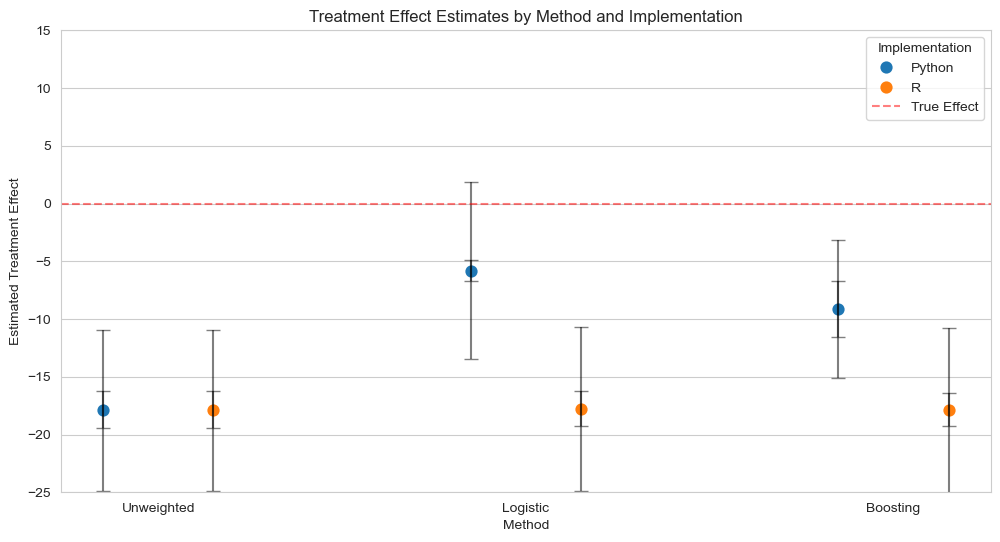

<Figure size 1200x800 with 0 Axes>

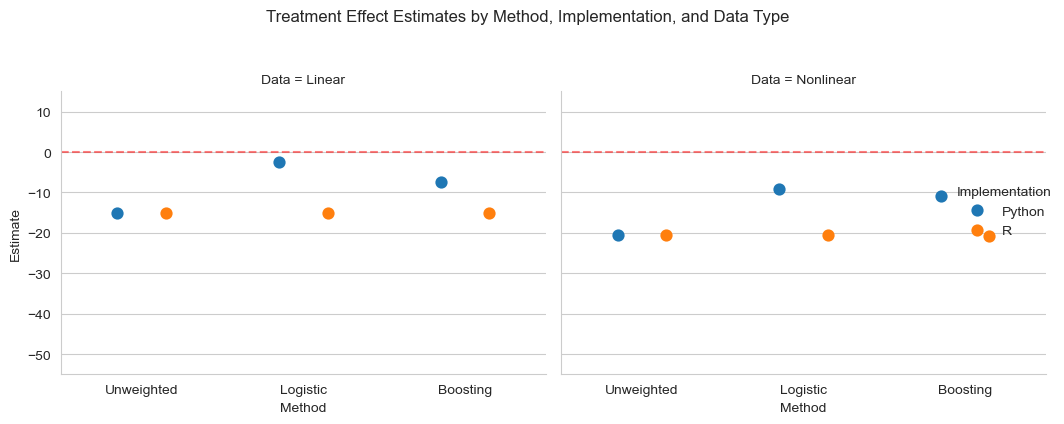


Computation Times (seconds):
  Implementation    Method       Data  Time (s)
0         Python  Logistic     Linear  0.009968
1         Python  Boosting     Linear  1.065978
2         Python  Logistic  Nonlinear  0.006869
3         Python  Boosting  Nonlinear  0.912691
4              R  Logistic     Linear  0.015074
5              R  Boosting     Linear  3.815308
6              R  Logistic  Nonlinear  0.064019
7              R  Boosting  Nonlinear  3.784381


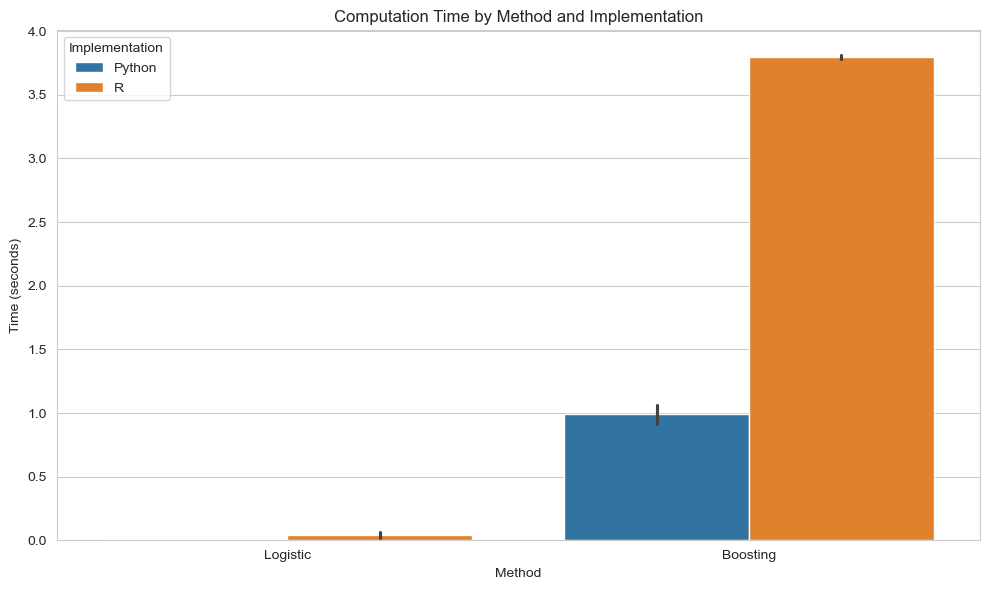

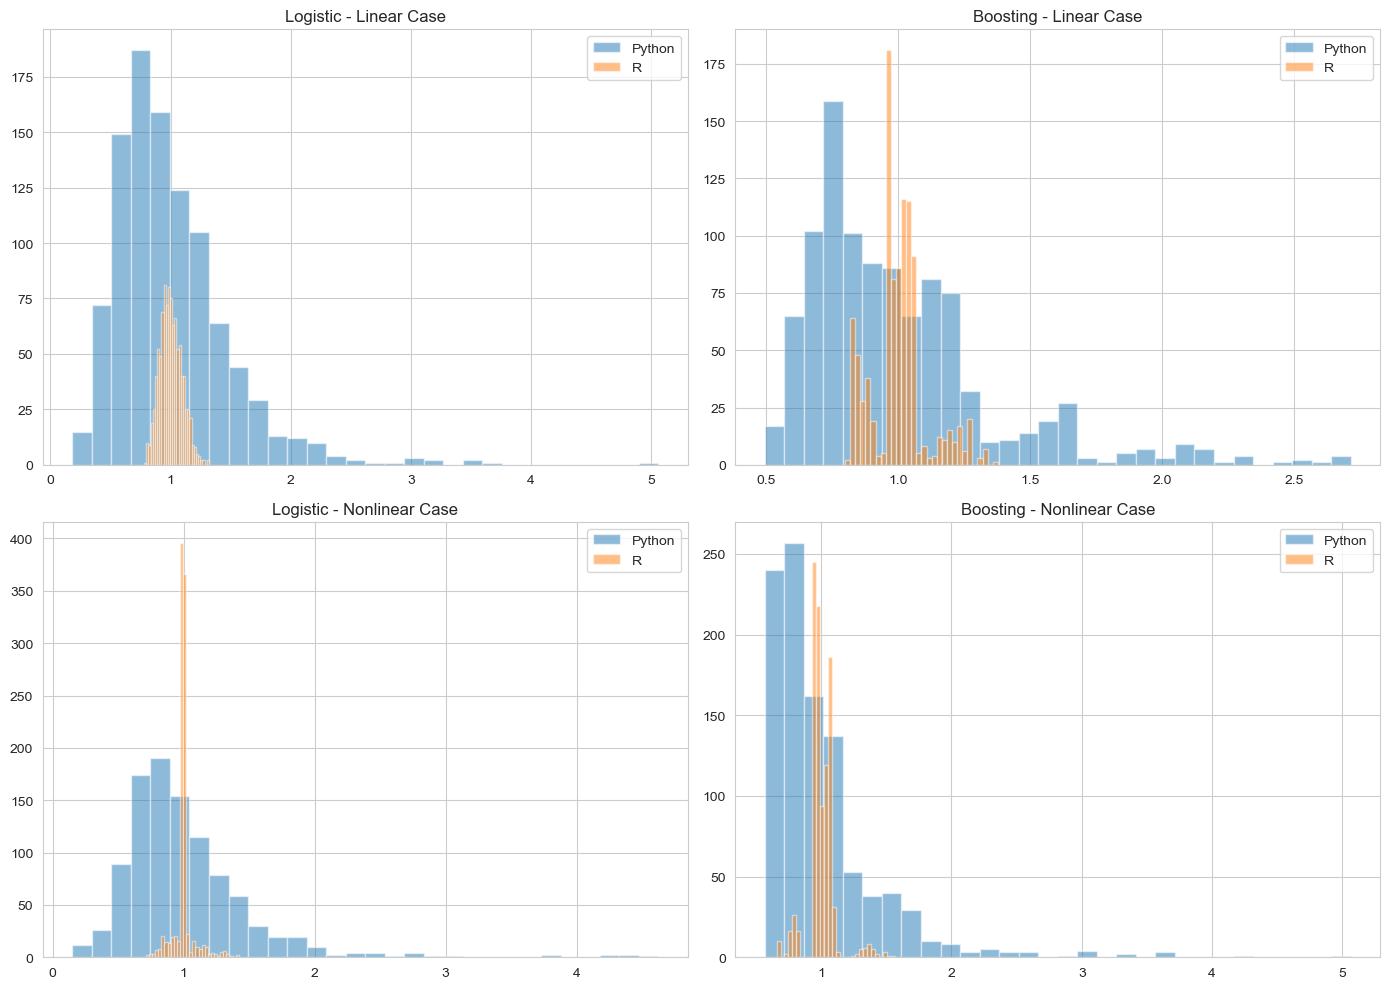

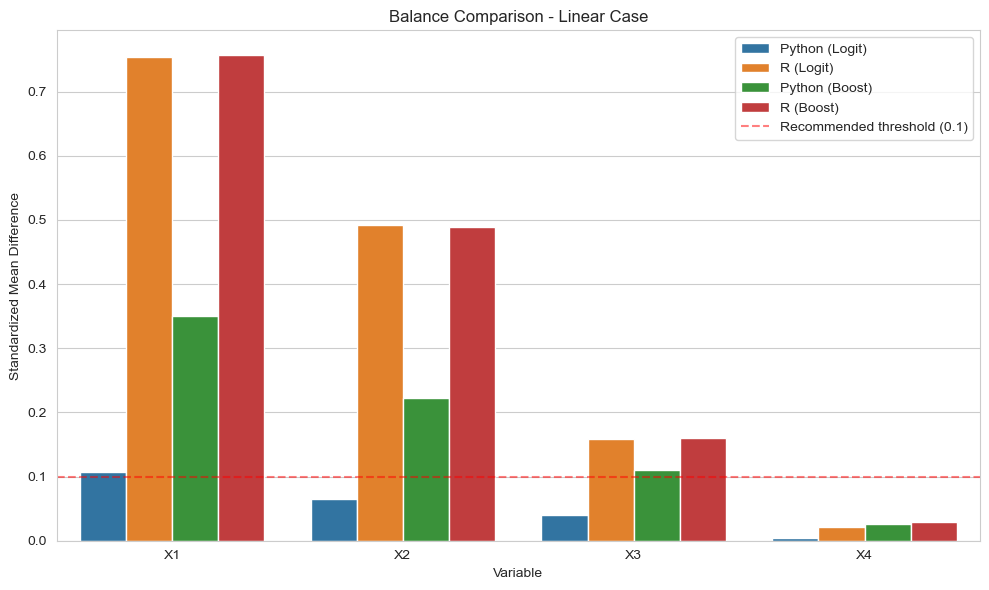

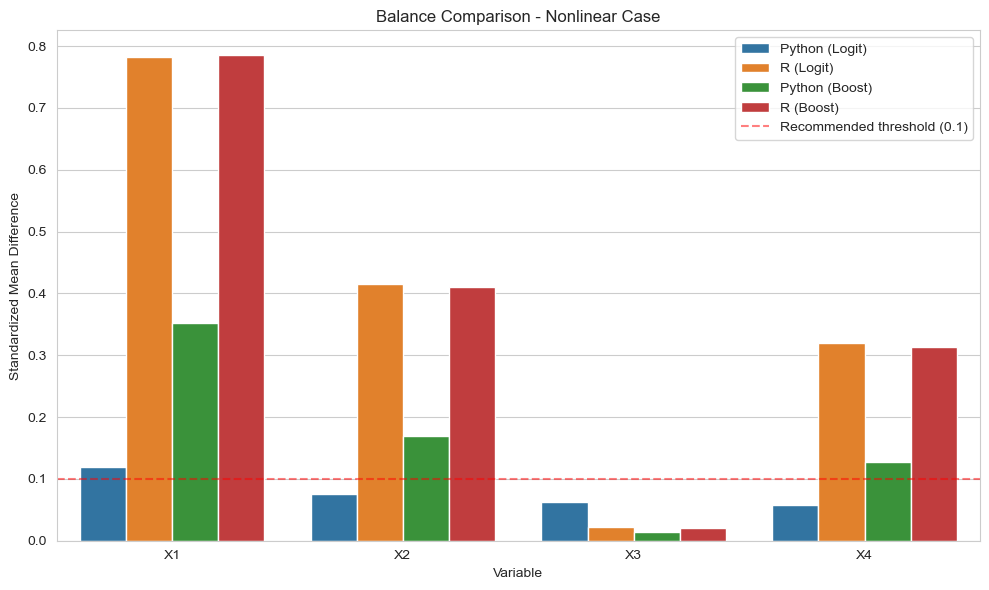


Balance Metrics - Linear Case (Standardized Mean Differences):
  Variable  Python (Logit)  R (Logit)  Python (Boost)  R (Boost)
0       X1        0.106963   0.754393        0.350343   0.757660
1       X2        0.065767   0.491806        0.222015   0.489724
2       X3        0.039401   0.159075        0.110233   0.160352
3       X4        0.003754   0.021118        0.025562   0.028706

Balance Metrics - Nonlinear Case (Standardized Mean Differences):
  Variable  Python (Logit)  R (Logit)  Python (Boost)  R (Boost)
0       X1        0.118925   0.782283        0.351393   0.786311
1       X2        0.075442   0.415369        0.168637   0.410696
2       X3        0.062627   0.022012        0.013613   0.020460
3       X4        0.057440   0.319357        0.127487   0.313989

Benchmarking SGD implementation on larger datasets...
Standard implementation time: 0.04 seconds
SGD implementation time: 0.68 seconds


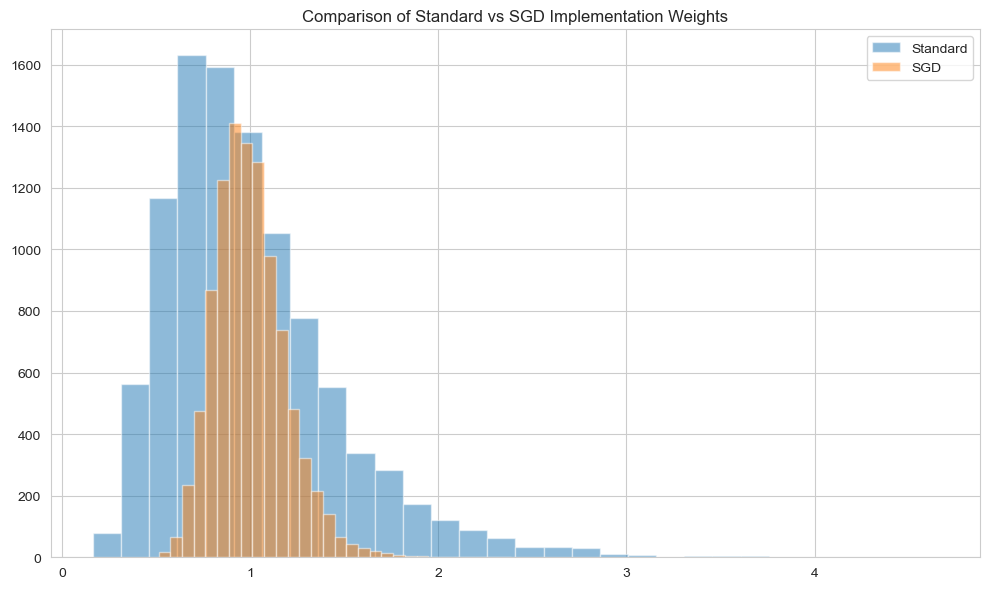


Standard implementation treatment effect: -3.1885 (SE: 0.6968)
SGD implementation treatment effect: -21.2967 (SE: 0.6995)
Speed improvement: 0.05x faster with SGD

Balance Comparison - Standard vs SGD:
  Variable  Standard       SGD
0       X1  0.116847  0.783241
1       X2  0.053362  0.382116
2       X3  0.033309  0.236607
3       X4  0.017774  0.117072


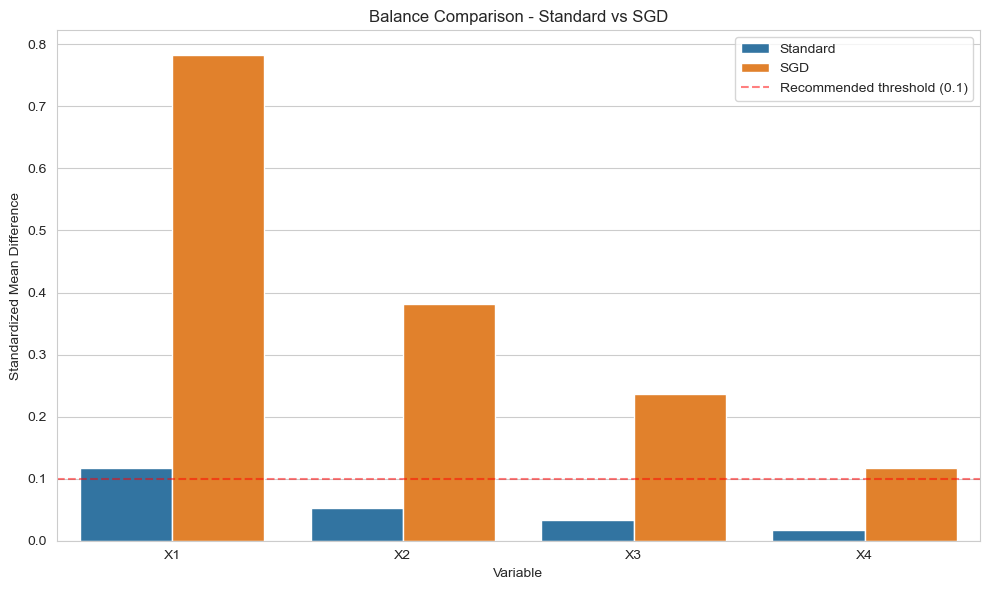

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import time

# Import our Python implementation
from permutation_weighting import PW

# Set up plotting
sns.set_style('whitegrid')
np.random.seed(42)

# Data Generation
def generate_kang_schafer_data(n=1000, nonlinear=False):
    """
    Generate data according to the Kang and Schafer (2007) simulation.
    
    Parameters
    ----------
    n : int
        Number of observations
    nonlinear : bool
        Whether to use nonlinear transformations of the covariates
        
    Returns
    -------
    X : array
        Covariate matrix
    A : array
        Treatment assignment
    Y : array
        Outcome values
    X_mis : array, optional
        Misspecified covariate matrix (if nonlinear=True)
    """
    # Generate covariates
    X = np.random.normal(size=(n, 4))
    
    # Generate propensity scores
    propensity = 1 / (1 + np.exp(X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]))
    
    # Generate treatment
    A = np.random.binomial(1, propensity, size=n)
    
    # Generate outcome (true treatment effect is 0)
    Y = 210 + 27.4 * X[:, 0] + 13.7 * X[:, 1] + 13.7 * X[:, 2] + 13.7 * X[:, 3] + np.random.normal(size=n)
    
    if nonlinear:
        # Create misspecified covariates
        X_mis = np.column_stack([
            np.exp(X[:, 0] / 2),
            X[:, 1] * (1 + np.exp(X[:, 0])) ** (-1) + 10,
            (X[:, 0] * X[:, 2] / 25 + 0.6) ** 3,
            (X[:, 1] + X[:, 3] + 20) ** 2
        ])
        return X, A, Y, X_mis
    else:
        return X, A, Y

# Generate data for both scenarios
n_samples = 1000
X, A, Y = generate_kang_schafer_data(n=n_samples, nonlinear=False)
X_mis, A_mis, Y_mis, X_nonlinear = generate_kang_schafer_data(n=n_samples, nonlinear=True)

# Helper function to compute balance metrics
def compute_balance(A, X, weights=None):
    """Compute standardized mean differences with optional weights"""
    if weights is None:
        weights = np.ones(len(A))
        
    # Standardize weights to sum to 1
    weights = weights / np.sum(weights)
    
    # Compute weighted means for treated and control
    treated_idx = A == 1
    control_idx = A == 0
    
    treated_weights = weights[treated_idx] / np.sum(weights[treated_idx])
    control_weights = weights[control_idx] / np.sum(weights[control_idx])
    
    treated_means = np.average(X[treated_idx], axis=0, weights=treated_weights)
    control_means = np.average(X[control_idx], axis=0, weights=control_weights)
    
    # Compute pooled standard deviation
    pooled_sd = np.sqrt(np.var(X, axis=0))
    
    # Standardized mean difference
    smd = np.abs(treated_means - control_means) / pooled_sd
    
    return smd

# Standardize features for improved model fitting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_nonlinear_scaled = scaler.fit_transform(X_nonlinear)

# Estimate weights with Python implementation
print("Estimating weights with Python implementation...")

# Linear case with improved parameters
start_time = time.time()
pw_logit_py = PW(A, X_scaled, classifier='logit', num_replicates=100,
                classifier_params={
                    'max_iter': 10000,
                    'C': 1.0,
                    'solver': 'liblinear'
                })
py_logit_time = time.time() - start_time

start_time = time.time()
pw_boost_py = PW(A, X_scaled, classifier='boosting', num_replicates=100,
                classifier_params={
                    'n_estimators': 200,
                    'max_depth': 4,
                    'learning_rate': 0.05
                })
py_boost_time = time.time() - start_time

# Nonlinear case with improved parameters
start_time = time.time()
pw_logit_mis_py = PW(A_mis, X_nonlinear_scaled, classifier='logit', num_replicates=100,
                    classifier_params={
                        'max_iter': 10000,
                        'C': 1.0,
                        'solver': 'liblinear'
                    })
py_logit_mis_time = time.time() - start_time

start_time = time.time()
pw_boost_mis_py = PW(A_mis, X_nonlinear_scaled, classifier='boosting', num_replicates=100,
                    classifier_params={
                        'n_estimators': 200,
                        'max_depth': 4,
                        'learning_rate': 0.05
                    })
py_boost_mis_time = time.time() - start_time

# Estimate treatment effects
# Linear case
unweighted_py = sm.OLS(Y, sm.add_constant(A)).fit()
logit_py = sm.WLS(Y, sm.add_constant(A), weights=pw_logit_py['weights']).fit()
boost_py = sm.WLS(Y, sm.add_constant(A), weights=pw_boost_py['weights']).fit()

# Nonlinear case
unweighted_mis_py = sm.OLS(Y_mis, sm.add_constant(A_mis)).fit()
logit_mis_py = sm.WLS(Y_mis, sm.add_constant(A_mis), weights=pw_logit_mis_py['weights']).fit()
boost_mis_py = sm.WLS(Y_mis, sm.add_constant(A_mis), weights=pw_boost_mis_py['weights']).fit()

# Extract results
py_unweighted = (unweighted_py.params[1], unweighted_py.bse[1])
py_logit = (logit_py.params[1], logit_py.bse[1])
py_boost = (boost_py.params[1], boost_py.bse[1])

py_unweighted_mis = (unweighted_mis_py.params[1], unweighted_mis_py.bse[1])
py_logit_mis = (logit_mis_py.params[1], logit_mis_py.bse[1])
py_boost_mis = (boost_mis_py.params[1], boost_mis_py.bse[1])

# Try to set up R connection
try:
    import rpy2
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter
    
    # Initialize R
    r = ro.r
    
    # Install the pw package if not already installed
    r('''
    if (!require("pw")) {
        if (!require("devtools")) {
            install.packages("devtools")
        }
        devtools::install_github("ddimmery/pw")
    }
    ''')
    
    # Import pw package
    pw_r = importr('pw')
    
    # Check if installation was successful
    print("R package 'pw' loaded successfully.")
    r_available = True
    
except Exception as e:
    print(f"Error setting up R connection: {e}")
    print("Will proceed with Python implementation only.")
    r_available = False
    
if r_available:
    print("Estimating weights with R implementation...")
    
    # Activate pandas conversion
    pandas2ri.activate()
    
    # Convert data to R
    r.assign("A", ro.FloatVector(A))
    r.assign("X", ro.r.matrix(ro.FloatVector(X.flatten()), nrow=X.shape[0], ncol=X.shape[1]))
    r.assign("Y", ro.FloatVector(Y))
    
    r.assign("A_mis", ro.FloatVector(A_mis))
    r.assign("X_mis", ro.r.matrix(ro.FloatVector(X_nonlinear.flatten()), nrow=X_nonlinear.shape[0], ncol=X_nonlinear.shape[1]))
    r.assign("Y_mis", ro.FloatVector(Y_mis))
    
    # Try to extract default parameters from R
    r('''
    # Get default parameters if possible
    if (exists("logit_factory", where = asNamespace("pw"))) {
        tryCatch({
            r_default_params <- formals(get("logit_factory", asNamespace("pw")))
            print(r_default_params)
        }, error = function(e) {
            print("Couldn't get default parameters")
        })
    }
    ''')
    
    # Estimate weights with logistic regression in R
    start_time = time.time()
    r('''
    set.seed(42)
    pw_logit_r <- PW(A, X, classifier="logit", num_replicates=100)
    ''')
    r_logit_time = time.time() - start_time
    
    start_time = time.time()
    r('''
    pw_logit_mis_r <- PW(A_mis, X_mis, classifier="logit", num_replicates=100)
    ''')
    r_logit_mis_time = time.time() - start_time
    
    # Estimate weights with boosting in R
    start_time = time.time()
    r('''
    pw_boost_r <- PW(A, X, classifier="boosting", num_replicates=100)
    ''')
    r_boost_time = time.time() - start_time
    
    start_time = time.time()
    r('''
    pw_boost_mis_r <- PW(A_mis, X_mis, classifier="boosting", num_replicates=100)
    ''')
    r_boost_mis_time = time.time() - start_time
    
    # Estimate ATE in R
    r('''
    unweighted_r <- lm(Y ~ A)
    logit_r <- lm(Y ~ A, weights=pw_logit_r$weights)
    boost_r <- lm(Y ~ A, weights=pw_boost_r$weights)
    
    unweighted_mis_r <- lm(Y_mis ~ A_mis)
    logit_mis_r <- lm(Y_mis ~ A_mis, weights=pw_logit_mis_r$weights)
    boost_mis_r <- lm(Y_mis ~ A_mis, weights=pw_boost_mis_r$weights)
    ''')
    
    # Extract results from R
    r_unweighted = (r('unweighted_r$coefficients[2]')[0], r('summary(unweighted_r)$coefficients[2, 2]')[0])
    r_logit = (r('logit_r$coefficients[2]')[0], r('summary(logit_r)$coefficients[2, 2]')[0])
    r_boost = (r('boost_r$coefficients[2]')[0], r('summary(boost_r)$coefficients[2, 2]')[0])
    
    r_unweighted_mis = (r('unweighted_mis_r$coefficients[2]')[0], r('summary(unweighted_mis_r)$coefficients[2, 2]')[0])
    r_logit_mis = (r('logit_mis_r$coefficients[2]')[0], r('summary(logit_mis_r)$coefficients[2, 2]')[0])
    r_boost_mis = (r('boost_mis_r$coefficients[2]')[0], r('summary(boost_mis_r)$coefficients[2, 2]')[0])
    
    # Extract weights from R for comparison
    r_weights_logit = r('pw_logit_r$weights')
    r_weights_boost = r('pw_boost_r$weights')
    r_weights_logit_mis = r('pw_logit_mis_r$weights')
    r_weights_boost_mis = r('pw_boost_mis_r$weights')
    
    # Compute balance metrics for comparison
    py_balance_logit = compute_balance(A, X, pw_logit_py['weights'])
    r_balance_logit = compute_balance(A, X, r_weights_logit)
    
    py_balance_boost = compute_balance(A, X, pw_boost_py['weights'])
    r_balance_boost = compute_balance(A, X, r_weights_boost)
    
    # Nonlinear case
    py_balance_logit_mis = compute_balance(A_mis, X_nonlinear, pw_logit_mis_py['weights'])
    r_balance_logit_mis = compute_balance(A_mis, X_nonlinear, r_weights_logit_mis)
    
    py_balance_boost_mis = compute_balance(A_mis, X_nonlinear, pw_boost_mis_py['weights'])
    r_balance_boost_mis = compute_balance(A_mis, X_nonlinear, r_weights_boost_mis)
    
    # Create balance comparison dataframe
    balance_df_linear = pd.DataFrame({
        'Variable': [f'X{i+1}' for i in range(X.shape[1])],
        'Python (Logit)': py_balance_logit,
        'R (Logit)': r_balance_logit,
        'Python (Boost)': py_balance_boost,
        'R (Boost)': r_balance_boost
    })
    
    balance_df_nonlinear = pd.DataFrame({
        'Variable': [f'X{i+1}' for i in range(X_nonlinear.shape[1])],
        'Python (Logit)': py_balance_logit_mis,
        'R (Logit)': r_balance_logit_mis,
        'Python (Boost)': py_balance_boost_mis,
        'R (Boost)': r_balance_boost_mis
    })
    
    # Deactivate pandas conversion
    pandas2ri.deactivate()
else:
    # If R is not available, create some dummy data for plotting
    r_unweighted = py_unweighted
    r_logit = py_unweighted
    r_boost = py_unweighted
    r_unweighted_mis = py_unweighted_mis
    r_logit_mis = py_unweighted_mis
    r_boost_mis = py_unweighted_mis
    r_logit_time = 0
    r_boost_time = 0
    r_logit_mis_time = 0
    r_boost_mis_time = 0
    r_weights_logit = np.ones_like(pw_logit_py['weights'])
    r_weights_boost = np.ones_like(pw_boost_py['weights'])
    r_weights_logit_mis = np.ones_like(pw_logit_mis_py['weights'])
    r_weights_boost_mis = np.ones_like(pw_boost_mis_py['weights'])

# Create comparison table for estimated treatment effects
results = []

# Python results
results.append(['Python', 'Unweighted', 'Linear', py_unweighted[0], py_unweighted[1]])
results.append(['Python', 'Logistic', 'Linear', py_logit[0], py_logit[1]])
results.append(['Python', 'Boosting', 'Linear', py_boost[0], py_boost[1]])
results.append(['Python', 'Unweighted', 'Nonlinear', py_unweighted_mis[0], py_unweighted_mis[1]])
results.append(['Python', 'Logistic', 'Nonlinear', py_logit_mis[0], py_logit_mis[1]])
results.append(['Python', 'Boosting', 'Nonlinear', py_boost_mis[0], py_boost_mis[1]])

# R results if available
if r_available:
    results.append(['R', 'Unweighted', 'Linear', r_unweighted[0], r_unweighted[1]])
    results.append(['R', 'Logistic', 'Linear', r_logit[0], r_logit[1]])
    results.append(['R', 'Boosting', 'Linear', r_boost[0], r_boost[1]])
    results.append(['R', 'Unweighted', 'Nonlinear', r_unweighted_mis[0], r_unweighted_mis[1]])
    results.append(['R', 'Logistic', 'Nonlinear', r_logit_mis[0], r_logit_mis[1]])
    results.append(['R', 'Boosting', 'Nonlinear', r_boost_mis[0], r_boost_mis[1]])

# Create DataFrame
results_df = pd.DataFrame(results, columns=['Implementation', 'Method', 'Data', 'Estimate', 'Std Error'])
results_df['Estimate'] = pd.to_numeric(results_df['Estimate'])
results_df['Std Error'] = pd.to_numeric(results_df['Std Error'])

# Add absolute bias column
results_df['Abs Bias'] = np.abs(results_df['Estimate'])  # True effect is 0

# Display results
print("\nTreatment Effect Estimates (true effect = 0):")
print(results_df)

# Create plot of treatment effects
plt.figure(figsize=(12, 6))
g = sns.pointplot(x='Method', y='Estimate', hue='Implementation', 
                 data=results_df, dodge=0.3, linestyles='none', errorbar=None)

# Add error bars
for i, row in results_df.iterrows():
    x = g.get_xticks()[results_df['Method'].unique().tolist().index(row['Method'])]
    if row['Implementation'] == 'Python':
        x -= 0.15
    else:
        x += 0.15
    
    plt.errorbar(x, row['Estimate'], yerr=1.96*row['Std Error'], fmt='none', capsize=5, 
                color='black', alpha=0.5)

# Add reference line for true effect
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='True Effect')

# Add labels and title
plt.title('Treatment Effect Estimates by Method and Implementation')
plt.ylabel('Estimated Treatment Effect')
plt.legend(title='Implementation')
plt.ylim(-25, 15)

# Create plot by data type
plt.figure(figsize=(12, 8))
g = sns.catplot(x='Method', y='Estimate', hue='Implementation', 
               col='Data', data=results_df, kind='point', 
               dodge=0.3, linestyles='none', errorbar=None, height=4, aspect=1.2)

# Add reference line for true effect
for ax in g.axes.flat:
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_ylim(-55, 15)

# Add title
g.fig.suptitle('Treatment Effect Estimates by Method, Implementation, and Data Type', y=1.05)

# Show plots
plt.tight_layout()
plt.show()

# Compare computation times
if r_available:
    time_results = []
    time_results.append(['Python', 'Logistic', 'Linear', py_logit_time])
    time_results.append(['Python', 'Boosting', 'Linear', py_boost_time])
    time_results.append(['Python', 'Logistic', 'Nonlinear', py_logit_mis_time])
    time_results.append(['Python', 'Boosting', 'Nonlinear', py_boost_mis_time])
    
    time_results.append(['R', 'Logistic', 'Linear', r_logit_time])
    time_results.append(['R', 'Boosting', 'Linear', r_boost_time])
    time_results.append(['R', 'Logistic', 'Nonlinear', r_logit_mis_time])
    time_results.append(['R', 'Boosting', 'Nonlinear', r_boost_mis_time])
    
    time_df = pd.DataFrame(time_results, columns=['Implementation', 'Method', 'Data', 'Time (s)'])
    
    print("\nComputation Times (seconds):")
    print(time_df)
    
    # Create plot of computation times
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Method', y='Time (s)', hue='Implementation', data=time_df)
    plt.title('Computation Time by Method and Implementation')
    plt.ylabel('Time (seconds)')
    plt.ylim(0, None)
    plt.tight_layout()
    plt.show()
    
    # Compare distribution of weights
    plt.figure(figsize=(14, 10))
    
    # Linear case
    plt.subplot(2, 2, 1)
    plt.hist(pw_logit_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_logit, bins=30, alpha=0.5, label='R')
    plt.title('Logistic - Linear Case')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.hist(pw_boost_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_boost, bins=30, alpha=0.5, label='R')
    plt.title('Boosting - Linear Case')
    plt.legend()
    
    # Nonlinear case
    plt.subplot(2, 2, 3)
    plt.hist(pw_logit_mis_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_logit_mis, bins=30, alpha=0.5, label='R')
    plt.title('Logistic - Nonlinear Case')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.hist(pw_boost_mis_py['weights'], bins=30, alpha=0.5, label='Python')
    plt.hist(r_weights_boost_mis, bins=30, alpha=0.5, label='R')
    plt.title('Boosting - Nonlinear Case')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot balance metrics
    if r_available:
        plt.figure(figsize=(10, 6))
        balance_df_linear_melted = pd.melt(balance_df_linear, id_vars=['Variable'], 
                                         var_name='Implementation', value_name='SMD')
        sns.barplot(x='Variable', y='SMD', hue='Implementation', data=balance_df_linear_melted)
        plt.title('Balance Comparison - Linear Case')
        plt.ylabel('Standardized Mean Difference')
        plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, 
                   label='Recommended threshold (0.1)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        balance_df_nonlinear_melted = pd.melt(balance_df_nonlinear, id_vars=['Variable'], 
                                            var_name='Implementation', value_name='SMD')
        sns.barplot(x='Variable', y='SMD', hue='Implementation', data=balance_df_nonlinear_melted)
        plt.title('Balance Comparison - Nonlinear Case')
        plt.ylabel('Standardized Mean Difference')
        plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, 
                   label='Recommended threshold (0.1)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Display balance statistics
        print("\nBalance Metrics - Linear Case (Standardized Mean Differences):")
        print(balance_df_linear)
        
        print("\nBalance Metrics - Nonlinear Case (Standardized Mean Differences):")
        print(balance_df_nonlinear)

# Add SGD Implementation Benchmarking
print("\nBenchmarking SGD implementation on larger datasets...")

# Generate a larger dataset
n_large = 10000
X_large, A_large, Y_large = generate_kang_schafer_data(n=n_large, nonlinear=False)
X_large_scaled = scaler.fit_transform(X_large)

# Standard implementation
start_time = time.time()
pw_std = PW(A_large, X_large_scaled, classifier='logit', num_replicates=10,
           classifier_params={'max_iter': 10000, 'solver': 'liblinear'})
std_time = time.time() - start_time
print(f"Standard implementation time: {std_time:.2f} seconds")

# SGD implementation
start_time = time.time()
pw_sgd = PW(A_large, X_large_scaled, classifier='logit', use_sgd=True, num_replicates=10)
sgd_time = time.time() - start_time
print(f"SGD implementation time: {sgd_time:.2f} seconds")

# Compare weights
plt.figure(figsize=(10, 6))
plt.hist(pw_std['weights'], bins=30, alpha=0.5, label='Standard')
plt.hist(pw_sgd['weights'], bins=30, alpha=0.5, label='SGD')
plt.title('Comparison of Standard vs SGD Implementation Weights')
plt.legend()
plt.tight_layout()
plt.show()

# Compare treatment effect estimates
std_model = sm.WLS(Y_large, sm.add_constant(A_large), weights=pw_std['weights']).fit()
sgd_model = sm.WLS(Y_large, sm.add_constant(A_large), weights=pw_sgd['weights']).fit()

print(f"\nStandard implementation treatment effect: {std_model.params[1]:.4f} (SE: {std_model.bse[1]:.4f})")
print(f"SGD implementation treatment effect: {sgd_model.params[1]:.4f} (SE: {sgd_model.bse[1]:.4f})")
print(f"Speed improvement: {std_time/sgd_time:.2f}x faster with SGD")

# Compute balance metrics for SGD vs standard
std_balance = compute_balance(A_large, X_large, pw_std['weights'])
sgd_balance = compute_balance(A_large, X_large, pw_sgd['weights'])

balance_df_sgd = pd.DataFrame({
    'Variable': [f'X{i+1}' for i in range(X_large.shape[1])],
    'Standard': std_balance,
    'SGD': sgd_balance
})

print("\nBalance Comparison - Standard vs SGD:")
print(balance_df_sgd)

plt.figure(figsize=(10, 6))
balance_df_sgd_melted = pd.melt(balance_df_sgd, id_vars=['Variable'], 
                              var_name='Implementation', value_name='SMD')
sns.barplot(x='Variable', y='SMD', hue='Implementation', data=balance_df_sgd_melted)
plt.title('Balance Comparison - Standard vs SGD')
plt.ylabel('Standardized Mean Difference')
plt.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, 
           label='Recommended threshold (0.1)')
plt.legend()
plt.tight_layout()
plt.show()